**Course website**: http://lagex.github.io/geofisica2

**Note**: This notebook is part of the course "Geofísica 2" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [IPython notebook](http://ipython.org/notebook.html). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (que pode ser números, texto, figuras, videos, etc).

# Prática 6 - Sísmica de reflexão: CMP, NMO e empilhamento

Nessa prática, vamos simular a aquisição de uma seção Common Mid Point (CMP). Vamos ver como utilizar a correção de Normal Moveout (NMO) para determinar a velocidade. Também vamos ver como o empilhamento melhora a razão sinal-ruído dos nossos dados.

Para isso, vamos utilizar as simulações de ondas da biblioteca [Fatiando a Terra](http://www.fatiando.org). Essas simulações utilizam o [método de diferenças finitas](http://en.wikipedia.org/wiki/Finite_difference_method) para calcular soluções da equação da onda.

As tarefas abaixo acompanham as questões que vocês devem responder. Usem as simulações abaixo para te ajudar a responder as perguntas.

## Preparação

Rode a célula abaixo para carregar as componentes necessárias para fazer as simulações. Não se preocupe se aparecer um `:0: FutureWarning: IPython widgets are experimental and may change in the future.` abaixo. Isso é consequência de utilizar tecnologia de ponta.

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from IPython.html import widgets
from IPython import display
from fatiando import utils
from fatiando.seismic.wavefd import Ricker, ElasticSH
from fatiando.vis import mpl
import fatiando
from multiprocessing import Pool

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
print(fatiando.__version__)

0.3-224-gb6a56f8


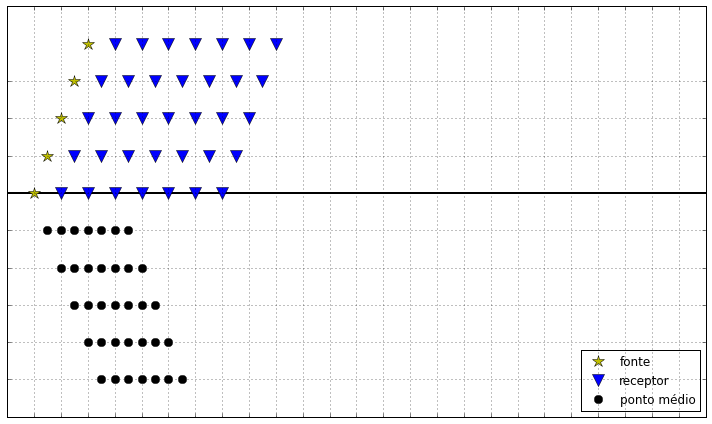

In [46]:
def plot_aquisicao(fontes, receptores, passo, raios, mesma_linha):
    offset = 2
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    fontes = np.arange(0, fontes*passo, passo)
    for i, f in enumerate(fontes):
        if mesma_linha:
            i = 0
        recep = f + np.arange(offset, offset*receptores, offset)
        mid = (f + recep)/2
        tmp = i*np.ones_like(recep)
        if raios:
            for r, m in zip(recep, mid):
                plt.plot([f, m, r], [i + 1, -i, i + 1], '-k')
        plotf, = plt.plot(f, i + 1, '*y', markersize=12)
        plotr, = plt.plot(recep, tmp + 1, 'vb', markersize=12)
        plotm, = plt.plot(mid, -tmp, 'ok', markersize=8) 
    plt.legend((plotf, plotr, plotm), 
               ('fonte', 'receptor', u'ponto médio'),
               numpoints=1, fancybox=False, loc='lower right')
    plt.xlim(-2, 50)
    plt.ylim(-5, 6)
    plt.xticks(range(-2, 50, 2))
    plt.yticks(range(-5, 5, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.hlines(1, -2, 50, linewidth=2)
    plt.grid()
    plt.tight_layout()
widgets.interactive(plot_aquisicao, fontes=(1, 5, 1), receptores=(1, 15, 1), passo=(0.5, 5, 0.5),
                    raios=False, mesma_linha=False)

In [3]:
shape = (150, 300)
spacing = 10
extent = [0, shape[1]*spacing, shape[0]*spacing, 0]
densidade = np.ones(shape)*1600
velocidade = np.ones(shape)*4000
l1 = shape[0]//2
densidade[l1:,:] = 1800
velocidade[l1:,:] = 5000
l2 = shape[0]//3
densidade[l2:l1, shape[1]//2:] = 1800
velocidade[l2:l1, shape[1]//2:] = 5000

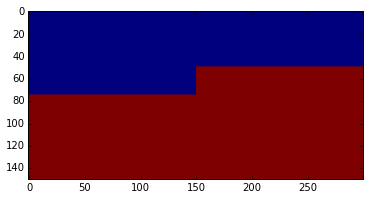

In [4]:
plt.imshow(densidade)

In [5]:
offset = 10
fontes = np.array(range(55, shape[1]//2, offset))
offsets = np.array(range(offset, 12*offset, offset))
print("Utilizando {} fontes e {} receptores.".format(len(fontes), len(offsets)))
print('Fontes:     {}'.format(fontes))
print('Offsets: {}'.format(offsets))

Utilizando 10 fontes e 11 receptores.
Fontes:     [ 55  65  75  85  95 105 115 125 135 145]
Offsets: [ 10  20  30  40  50  60  70  80  90 100 110]


In [6]:
def run_sim(fonte, its=700):    
    sim = ElasticSH(velocidade, densidade, spacing=spacing, taper=0.005, padding=45, verbose=False)
    sim.add_point_source((0, fonte), Ricker(5, 40, 2/40))
    sim.run(its)
    return sim

In [7]:
print('Simulando...')
pool = Pool()
sims = pool.map(run_sim, fontes)
pool.close()
print('Terminado.')

Simulando...
Terminado.


In [8]:
sims[6].animate(20, embed=True, dpi=50, fps=5, cutoff=0.0002, cmap='Greys')

In [ ]:
dt = sims[0].dt
times = np.linspace(0, dt*sims[0].size, sims[0].size)
recep = fontes[0]
CMP = np.empty((sims[0].size, len(recep)))
for i, sim in enumerate(sims):
    CMP[:, i] = sim[:, 0, recep[i]]

plt.figure(figsize=(6, 6))
plt.title("CMP")
mpl.seismic_image(CMP, dt=sims[0].dt, vmin=-0.00001, vmax=0.00001, aspect=20)
plt.xlabel(u'# traço')
plt.ylabel('tempo (s)')
plt.tight_layout()